# Predicting Stock Price with LSTM
- https://www.kaggle.com/darkknight91/ge-stock
- https://towardsdatascience.com/predicting-stock-price-with-lstm-13af86a74944

In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0-alpha0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## 1. Loading the Dataset (Pandas)

- This data file has approximately 55 years of stock price data for GE for US

In [3]:
df_ge = pd.read_csv("ge.us.txt")
df_ge.head(10)

,Date,Open,High,Low,Close,Volume,OpenInt
0,1962-01-02,0.6277,0.6362,0.6201,0.6201,2575579,0
1,1962-01-03,0.6201,0.6201,0.6122,0.6201,1764749,0
2,1962-01-04,0.6201,0.6201,0.6037,0.6122,2194010,0
3,1962-01-05,0.6122,0.6122,0.5798,0.5957,3255244,0
4,1962-01-08,0.5957,0.5957,0.5716,0.5957,3696430,0
5,1962-01-09,0.5957,0.6037,0.5878,0.5957,2778285,0
6,1962-01-10,0.5957,0.6037,0.5957,0.5957,2337096,0
7,1962-01-11,0.5957,0.5957,0.5878,0.5957,1943605,0
8,1962-01-12,0.5957,0.6037,0.5878,0.5878,2015151,0
9,1962-01-15,0.5957,0.5957,0.5957,0.5957,2527879,0


In [4]:
df_ge.tail(10)

,Date,Open,High,Low,Close,Volume,OpenInt
14048,2017-10-30,20.58,20.720,20.26,20.41,98376937,0
14049,2017-10-31,20.26,20.400,20.05,20.16,97991348,0
14050,2017-11-01,20.07,20.520,19.96,20.02,91707602,0
14051,2017-11-02,20.05,20.075,19.63,19.94,81528545,0
14052,2017-11-03,19.92,20.330,19.86,20.14,67855385,0
14053,2017-11-06,20.52,20.530,20.08,20.13,60641787,0
14054,2017-11-07,20.17,20.250,20.12,20.21,41622851,0
14055,2017-11-08,20.21,20.320,20.07,20.12,39672190,0
14056,2017-11-09,20.04,20.071,19.85,19.99,50831779,0
14057,2017-11-10,19.98,20.680,19.90,20.49,100698474,0


- checking if any null values are present

In [5]:
df_ge.isna().sum()

Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
OpenInt    0
dtype: int64

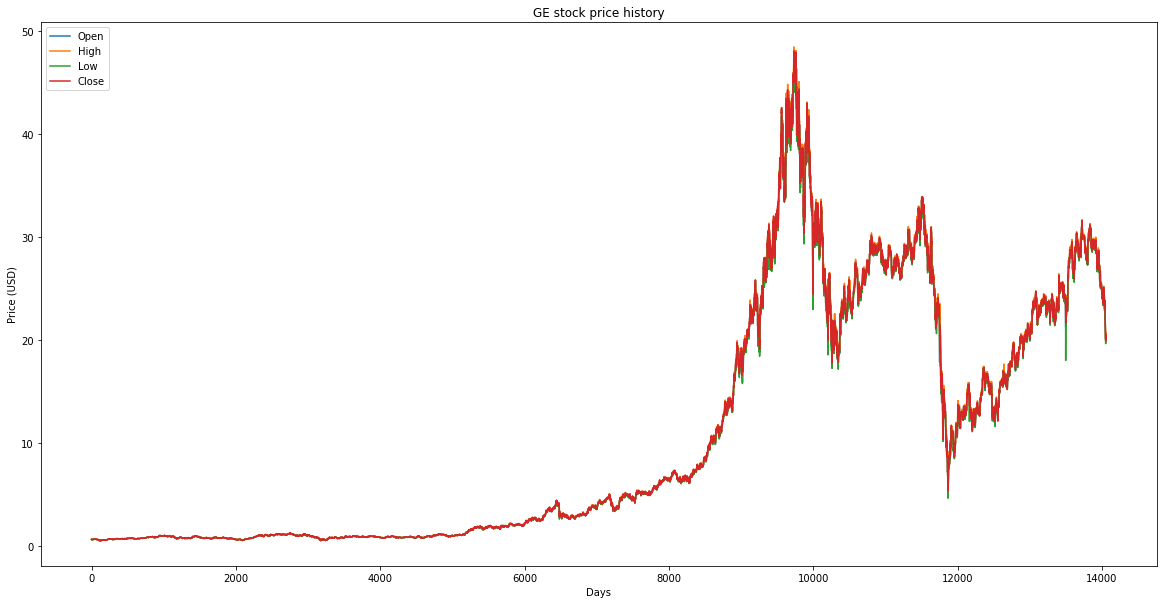

In [6]:
plt.rcParams['figure.figsize'] = [20, 10]

plt.figure()
plt.plot(df_ge["Open"])
plt.plot(df_ge["High"])
plt.plot(df_ge["Low"])
plt.plot(df_ge["Close"])
plt.title('GE stock price history')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.show()

## 2. Normalizing the data. (SkLearn)

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

train_cols = ["Open", "High", "Low", "Close", "Volume"]

df_train, df_test = train_test_split(df_ge, train_size=0.8, test_size=0.2, shuffle=False)

print("Train Size: {0}, Test Size: {1}".format(len(df_train), len(df_test)))

Train Size: 11246, Test Size: 2812


In [8]:
# scale the feature MinMax, build array
x_train_raw = df_train.loc[:, train_cols].values
min_max_scaler = MinMaxScaler()
x_train_raw = min_max_scaler.fit_transform(x_train_raw)

x_test_raw = df_test.loc[:, train_cols].values
x_test_raw = min_max_scaler.transform(x_test_raw)

In [9]:
print(x_train_raw[0:10])

[[0.00356678 0.00352766 0.00358385 0.00338425 0.02108267]
 [0.00340607 0.00319219 0.00341628 0.00338425 0.01365459]
 [0.00340607 0.00319219 0.00323598 0.00321827 0.01758709]
 [0.00323903 0.00302758 0.00272904 0.00287161 0.02730914]
 [0.00289013 0.00268378 0.0025551  0.00287161 0.03135089]
 [0.00289013 0.00285047 0.00289873 0.00287161 0.02293968]
 [0.00289013 0.00285047 0.00306629 0.00287161 0.01889791]
 [0.00289013 0.00268378 0.00289873 0.00287161 0.01529311]
 [0.00289013 0.00285047 0.00289873 0.00270563 0.01594855]
 [0.00289013 0.00268378 0.00306629 0.00287161 0.02064569]]


In [10]:
print(x_test_raw[0:10])

[[0.58098604 0.57472167 0.57944514 0.57965821 0.30279224]
 [0.57842746 0.5750759  0.57959362 0.57869176 0.2306256 ]
 [0.58445385 0.57740962 0.583348   0.57984729 0.3773507 ]
 [0.58016137 0.57674284 0.58152384 0.58016244 0.2578744 ]
 [0.58375606 0.5750759  0.58133294 0.57984729 0.20985472]
 [0.58390408 0.57857647 0.58213896 0.58272563 0.27612942]
 [0.58445385 0.57576351 0.57533016 0.57289307 0.29754321]
 [0.57527682 0.56903324 0.57564833 0.57219975 0.19681577]
 [0.57474819 0.57636778 0.57670889 0.58054061 0.25308053]
 [0.58445385 0.58778632 0.58627515 0.58986894 0.40572148]]


## 3. Converting data to time-series and supervised learning problem

![](https://cdn-images-1.medium.com/max/1600/1*bY3O4LR2IpgqwwFXHDmTbA.png)

In [11]:
TIME_STEPS = 3

In [12]:
# "conda install tqdm" is needed
from tqdm import tqdm_notebook

def build_timeseries(mat, y_col_index):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
    for i in tqdm_notebook(range(dim_0)):  
        x[i] = mat[i: TIME_STEPS + i]
        y[i] = mat[TIME_STEPS + i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

In [13]:
l = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
l = l[:-3]
print(l)

[0, 1, 2, 3, 4, 5, 6]


In [14]:
BATCH_SIZE = 20

In [15]:
def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0] % batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [16]:
x_temp, y_temp = build_timeseries(mat=x_train_raw, y_col_index=3)
x_train = trim_dataset(x_temp, BATCH_SIZE)
y_train = trim_dataset(y_temp, BATCH_SIZE)

x_temp, y_temp = build_timeseries(mat=x_test_raw, y_col_index=3)
x_val, x_test = np.split(trim_dataset(x_temp, BATCH_SIZE), 2)
x_val = trim_dataset(x_val, BATCH_SIZE)
x_test = trim_dataset(x_test, BATCH_SIZE)

y_val, y_test = np.split(trim_dataset(y_temp, BATCH_SIZE), 2)
y_val = trim_dataset(y_val, BATCH_SIZE)
y_test = trim_dataset(y_test, BATCH_SIZE)


length of time-series i/o (11243, 3, 5) (11243,)



length of time-series i/o (2809, 3, 5) (2809,)


In [17]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(11240, 3, 5) (11240,)
(1400, 3, 5) (1400,)
(1400, 3, 5) (1400,)


## 4. Creating model (tf20 + Keras)

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras import optimizers

lstm_model = Sequential()
lstm_model.add(LSTM(
    units=100, 
    batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_train.shape[2]),
    stateful=True,
    kernel_initializer='glorot_normal',
    bias_initializer='zero'
))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(
    units=25,
    kernel_initializer='glorot_normal',
    bias_initializer='zero',
    activation='relu'
))
lstm_model.add(Dense(
    units=1,
    kernel_initializer='glorot_normal',
    bias_initializer='zero',
    activation='sigmoid'
))

nesterov = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
lstm_model.compile(loss='mean_squared_error', optimizer=nesterov)

In [19]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
unified_lstm (UnifiedLSTM)   (20, 100)                 42400     
_________________________________________________________________
dropout (Dropout)            (20, 100)                 0         
_________________________________________________________________
dense (Dense)                (20, 25)                  2525      
_________________________________________________________________
dense_1 (Dense)              (20, 1)                   26        
Total params: 44,951
Trainable params: 44,951
Non-trainable params: 0
_________________________________________________________________


## 5. Training model (tf20 + Keras)

In [20]:
from tensorflow.keras.callbacks import Callback

class LossHistory(Callback):
    def __init__(self, lstm_model):
        self.lstm_model = lstm_model
        self.epoch = 0
        self.train_losses = []
        self.val_losses = []        

    def on_epoch_end(self, batch, logs={}):
        self.train_losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        if self.epoch % 10 == 0:
            print("epoch: {0} - train loss: {1:8.6f} - val loss: {2:8.6f}".format(
                self.epoch, 
                logs.get('loss'),
                logs.get('val_loss'),                
            ))
        self.lstm_model.reset_states()
        self.epoch += 1

In [21]:
from tensorflow.keras.callbacks import EarlyStopping

num_epochs = 500

history = LossHistory(lstm_model=lstm_model)  # 손실 이력 객체 생성
early_stopping = EarlyStopping(monitor='val_loss', patience=7)

lstm_model.fit(
    x=x_train, 
    y=y_train,
    epochs=num_epochs,
    verbose=0,
    batch_size=BATCH_SIZE,
    shuffle=False,
    validation_data=(x_val, y_val), 
    callbacks=[history, early_stopping]
)

epoch: 0 - train loss: 0.024604 - val loss: 0.037506
epoch: 10 - train loss: 0.001976 - val loss: 0.009626
epoch: 20 - train loss: 0.001341 - val loss: 0.008365
epoch: 30 - train loss: 0.001009 - val loss: 0.007069
epoch: 40 - train loss: 0.000847 - val loss: 0.006212
epoch: 50 - train loss: 0.000688 - val loss: 0.005580
epoch: 60 - train loss: 0.000585 - val loss: 0.005352
epoch: 70 - train loss: 0.000517 - val loss: 0.005171
epoch: 80 - train loss: 0.000460 - val loss: 0.004682
epoch: 90 - train loss: 0.000424 - val loss: 0.004254
epoch: 100 - train loss: 0.000387 - val loss: 0.003944
epoch: 110 - train loss: 0.000390 - val loss: 0.003471
epoch: 120 - train loss: 0.000361 - val loss: 0.003405
epoch: 130 - train loss: 0.000364 - val loss: 0.003142
epoch: 140 - train loss: 0.000350 - val loss: 0.002926
epoch: 150 - train loss: 0.000324 - val loss: 0.002896
epoch: 160 - train loss: 0.000340 - val loss: 0.002909


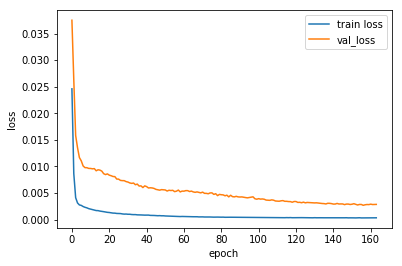

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.train_losses)
plt.plot(history.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val_loss'], loc='upper right')
plt.show()

## 6. Prediction

In [27]:
pred = lstm_model.predict(x_test)

In [28]:
print(y_test.shape, pred.shape)

(1400,) (1400, 1)


In [29]:
y_test_reverted = np.zeros(shape=(y_test.shape[0], 5))
print(y_test_reverted.shape)
y_test_reverted[:, 3] = y_test

y_test_reverted = min_max_scaler.inverse_transform(y_test_reverted)
print(y_test_reverted)

(1400, 5)
[[4.5902e-01 4.6690e-01 4.5114e-01 1.5754e+01 2.7425e+05]
 [4.5902e-01 4.6690e-01 4.5114e-01 1.5979e+01 2.7425e+05]
 [4.5902e-01 4.6690e-01 4.5114e-01 1.6224e+01 2.7425e+05]
 ...
 [4.5902e-01 4.6690e-01 4.5114e-01 2.1320e+01 2.7425e+05]
 [4.5902e-01 4.6690e-01 4.5114e-01 2.0790e+01 2.7425e+05]
 [4.5902e-01 4.6690e-01 4.5114e-01 2.0410e+01 2.7425e+05]]


In [30]:
pred_reverted = np.zeros(shape=(pred.shape[0], 5))
print(pred_reverted.shape)
pred_reverted[:, 3] = pred.reshape(-1,)

pred_reverted = min_max_scaler.inverse_transform(pred_reverted)
print(pred_reverted)

(1400, 5)
[[4.59020000e-01 4.66900000e-01 4.51140000e-01 1.90941241e+01
  2.74250000e+05]
 [4.59020000e-01 4.66900000e-01 4.51140000e-01 1.87847618e+01
  2.74250000e+05]
 [4.59020000e-01 4.66900000e-01 4.51140000e-01 1.87342349e+01
  2.74250000e+05]
 ...
 [4.59020000e-01 4.66900000e-01 4.51140000e-01 2.04615472e+01
  2.74250000e+05]
 [4.59020000e-01 4.66900000e-01 4.51140000e-01 2.02105109e+01
  2.74250000e+05]
 [4.59020000e-01 4.66900000e-01 4.51140000e-01 1.99130443e+01
  2.74250000e+05]]


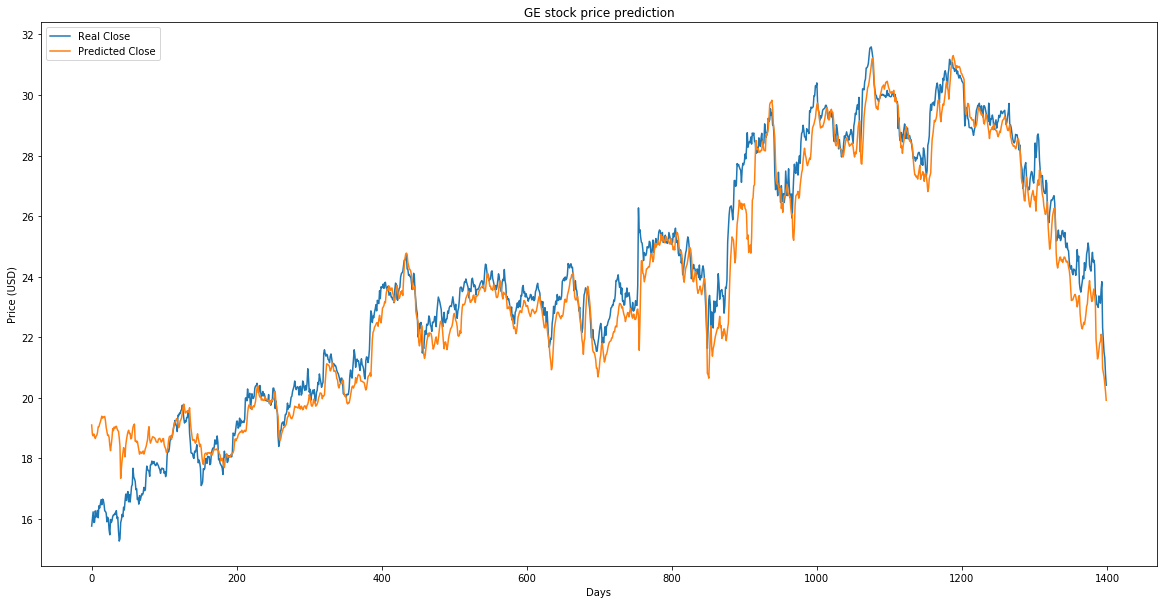

In [31]:
plt.rcParams['figure.figsize'] = [20, 10]

plt.figure()
plt.plot(y_test_reverted[:, 3])
plt.plot(pred_reverted[:, 3])
plt.title('GE stock price prediction')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Real Close','Predicted Close'], loc='upper left')
plt.show()

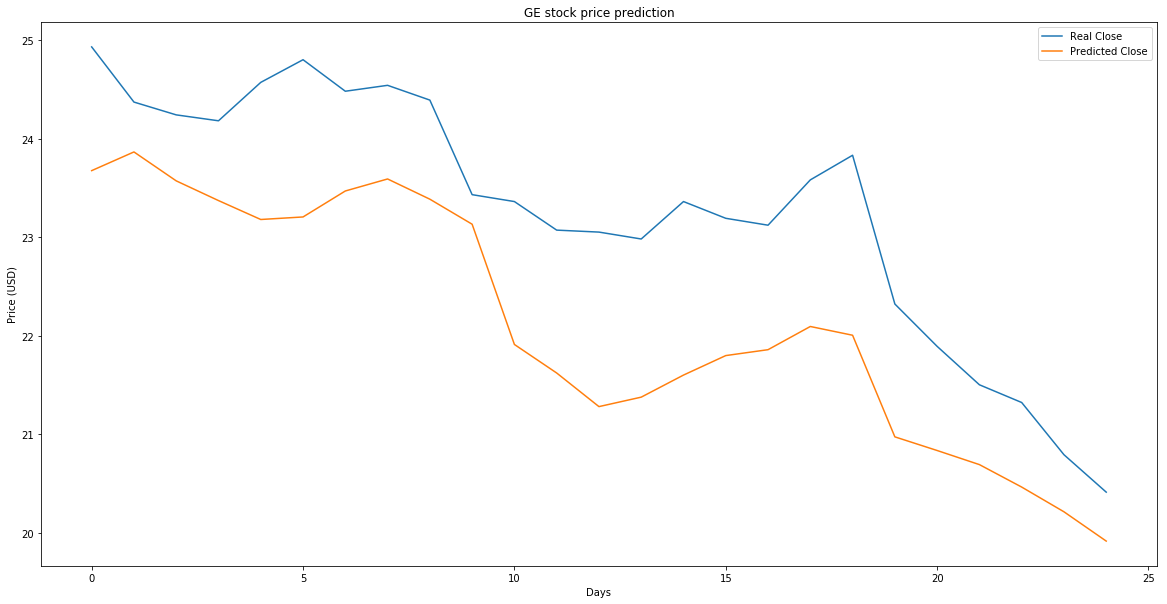

In [32]:
plt.rcParams['figure.figsize'] = [20, 10]

plt.figure()
plt.plot(y_test_reverted[:, 3][-25:])
plt.plot(pred_reverted[:, 3][-25:])
plt.title('GE stock price prediction')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Real Close','Predicted Close'], loc='upper right')
plt.show()